COVID19 FORECAST -- Pythonでの予測
==============
-------------

ここでは時系列分析によく使われる ***SARIMAXモデル*** でコロナウイルス新規陽性者数の28日後予測値を推定します。  
SARIMAXモデルは単変量の自己回帰モデルなので、データセットの陽性者数の列のみを使用しています。  

手順
+ 1. 必要なライブラリのインポート
+ 2. データの読み込みと可視化(pandas)
+ 3. SARIMAXでモデリング(statsmodels)
+ 4. データ予測(28日後予測)
+ 5. 実績値と予測値をつなげて可視化


## 1. 必要なライブラリのインポート

In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import japanize_matplotlib

## 2. データの読み込みと可視化(pandas)

In [2]:
df = pd.read_csv('sarima_data.csv', index_col=0)
df

,PCR 検査陽性者数(単日)
日付,
2020/2/4,2
2020/2/5,2
2020/2/6,0
2020/2/7,0
2020/2/8,0
...,...
2020/11/24,1217
2020/11/25,1930
2020/11/26,2499


In [3]:
df.columns = ['actual']
df

,actual
日付,
2020/2/4,2
2020/2/5,2
2020/2/6,0
2020/2/7,0
2020/2/8,0
...,...
2020/11/24,1217
2020/11/25,1930
2020/11/26,2499


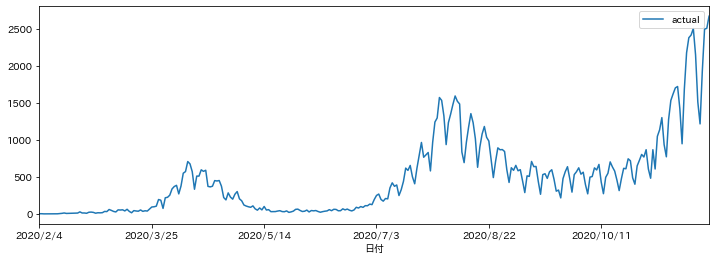

In [4]:
# positive(陽性者数)を折れ線グラフで見る
df.plot(figsize=(12,4))

In [5]:
df.actual

日付
2020/2/4         2
2020/2/5         2
2020/2/6         0
2020/2/7         0
2020/2/8         0
              ... 
2020/11/24    1217
2020/11/25    1930
2020/11/26    2499
2020/11/27    2510
2020/11/28    2674
Name: actual, Length: 299, dtype: int64

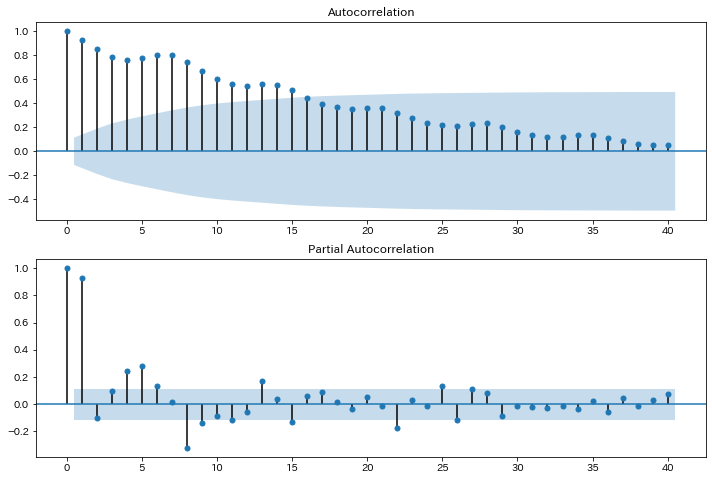

In [6]:
#  自己相関のグラフ
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df.actual, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df.actual, lags=40, ax=ax2)

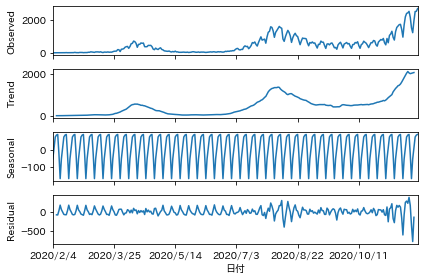

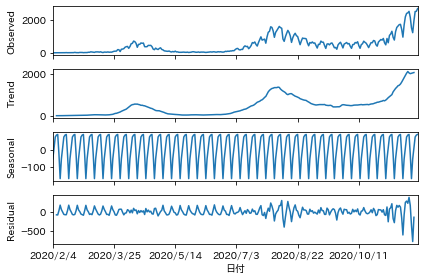

In [7]:
# データをトレンドと季節成分に分解
# 今回はdailyのデータということで1週間周期(freq=7)として設定
seasonal_decompose_res = sm.tsa.seasonal_decompose(df.actual, freq=7)
seasonal_decompose_res.plot()

## 3. SARIMAXでモデリング(statsmodels)

In [8]:
# 最適なパラメータを探す

In [9]:
# 総当たりで、AICが最小となるSARIMAの次数を探す
import warnings
warnings.simplefilter('ignore')

max_p = 3
max_q = 3
max_d = 2
max_sp = 1
max_sq = 1
max_sd = 1

pattern = max_p*(max_d + 1)*(max_q + 1)*(max_sp + 1)*(max_sq + 1)*(max_sd + 1)

modelSelection = pd.DataFrame(index=range(pattern), columns=["model", "aic"])

# 自動SARIMA選択
num = 0

for p in range(1, max_p + 1):
    for d in range(0, max_d + 1):
        for q in range(0, max_q + 1):
            for sp in range(0, max_sp + 1):
                for sd in range(0, max_sd + 1):
                    for sq in range(0, max_sq + 1):
                        sarima = sm.tsa.SARIMAX(
                            df.actual, order=(p,d,q), 
                            seasonal_order=(sp,sd,sq,7), 
                            enforce_stationarity = False, 
                            enforce_invertibility = False
                        ).fit()
                        modelSelection.ix[num]["model"] = "order=(" + str(p) + ","+ str(d) + ","+ str(q) + "), season=("+ str(sp) + ","+ str(sd) + "," + str(sq) + ")"
                        modelSelection.ix[num]["aic"] = sarima.aic
                        num = num + 1

In [10]:
# aicが小さい順に並べかえ
modelSelection.sort_values(by='aic').head()

,model,aic
251,"order=(3,1,3), season=(0,1,1)",3460.09
159,"order=(2,1,3), season=(1,1,1)",3460.37
255,"order=(3,1,3), season=(1,1,1)",3461.99
63,"order=(1,1,3), season=(1,1,1)",3463.91
283,"order=(3,2,3), season=(0,1,1)",3466.64


In [11]:
# sarimaのパラメータは order=(3,1,3), seasonal_order=(0,1,1,7)でAICが最小になるようなので、これを採用します

In [17]:
# モデル推定
sarima = sm.tsa.SARIMAX(df.actual, 
                          order=(3,1,3),
                          seasonal_order=(0,1,1,7),
                          enforce_stationarity=False,
                          enforce_invertibility=False).fit()

## 4. データ予測

In [18]:
# 28日後予測
prediction = sarima.forecast(28)

In [19]:
# 予測値をDataFrameにまとめる
dic = {'sarima_prediction':prediction}
sarima_prediction = pd.DataFrame(dic)
sarima_prediction

,sarima_prediction
2020-11-29,2287.134050
2020-11-30,1758.384233
2020-12-01,1829.055628
2020-12-02,2060.782174
2020-12-03,2349.113648
2020-12-04,2467.809837
2020-12-05,2673.343107
2020-12-06,2450.661545
2020-12-07,2092.776866
2020-12-08,2261.718137


In [20]:
# 上のdfをcsvとして保存しておく
sarima_prediction.to_csv('sarima_predict.csv', index=False)

## 5. 実績値と予測値をつなげて可視化

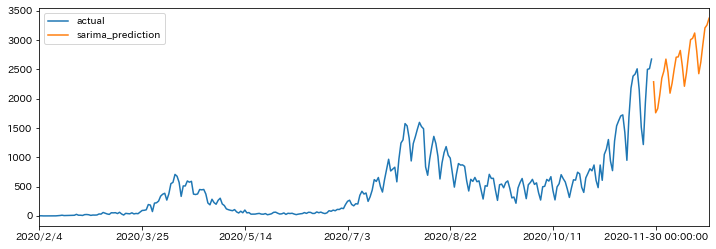

In [21]:
# 実績値（df）と予測値（sarima_prediction）をconcatして可視化
concat = pd.concat([df, sarima_prediction],sort=True)
concat.plot(figsize=(12,4))